# Convert word into templated sentence

Convert goals

In [85]:
import re
from num2words import num2words
def goal_translate(goals):
    goal_trans = ''
    sub_goal = ''
    for goal in goals:
        act = re.findall(r'\w+\b', goal)
        if len(act)==2:
            sub_goal = '{} the {}'.format(act[0],act[1])
        if len(act)==4:
            sub_goal = 'put {} {} {} {}'.format(num2words(act[3]),act[1], act[0], act[2])
        goal_trans = goal_trans + sub_goal + ', '
    goal_trans = goal_trans.lower()
    goal_trans = goal_trans[:-2] + '.'
    return goal_trans

goals = ['INSIDE (cutleryfork, dishwasher): 3','ON (wineglass, sink): 2','INSIDE (waterglass, dishwasher): 1',
         'CLOSE (dishwasher)','TURNON (dishwasher)']
print(goal_translate(goals))

put three cutleryfork inside dishwasher, put two wineglass on sink, put one waterglass inside dishwasher, close the dishwasher, turnon the dishwasher.


Convert history

In [86]:
verb_trans = {'standup': 'stood up',
              'walk': 'walked to',
              'sit': 'sit on',
              'grab': 'grabbed',
              'open': 'opened',
              'close': 'closed',
              'switchon': 'switched on',
              'switchoff': 'switched off',
              'put': ['put', 'on'],
              'putin': ['put', 'inside']}

def history_translate(history):
    history_trans = 'I have '
    for sub in history:
        sub = sub.split(' ')
        if len(sub) == 2:
            history_trans +=  '{}, '.format(verb_trans[sub[1][1: -1]])
        elif len(sub) == 4:
            history_trans += '{} the {}, '.format(verb_trans[sub[1][1: -1]], sub[2][1: -1])
        elif len(sub) == 6:
            history_trans += '{} the {} {} the {}, '.format(verb_trans[sub[1][1: -1]][0], sub[2][1: -1], verb_trans[sub[1][1: -1]][1], sub[4][1: -1])
    history_trans = history_trans[:-2] + '.'
    return history_trans

history = ['<char0> [walk] <coffeepot> (161)', '<char0> [grab] <coffeepot> (161)']
history_translate(history)

'I have walked to the coffeepot, grabbed the coffeepot.'

# Get Partial Observations

Enter virtualhome environment

In [4]:
import IPython.display
from virtualhome.demo.utils_demo import *
from sys import platform
import matplotlib.pyplot as plt
from virtualhome.simulation.unity_simulator.comm_unity import UnityCommunication
from virtualhome.simulation.unity_simulator import utils_viz

mode = 'manual'
if mode == 'auto':
    if platform == 'darwin':
        exec_file = '../simulation/macos_exec'
    else:
        exec_file = '../simulation/exec_linux.x86_64'
    comm = UnityCommunication(file_name=exec_file)
else:
    comm = UnityCommunication()

Define the functions to add a character into the environment, get the objects that are visible in the character's view, obtain the name, state and positions of these objects, and get the edge information among objects

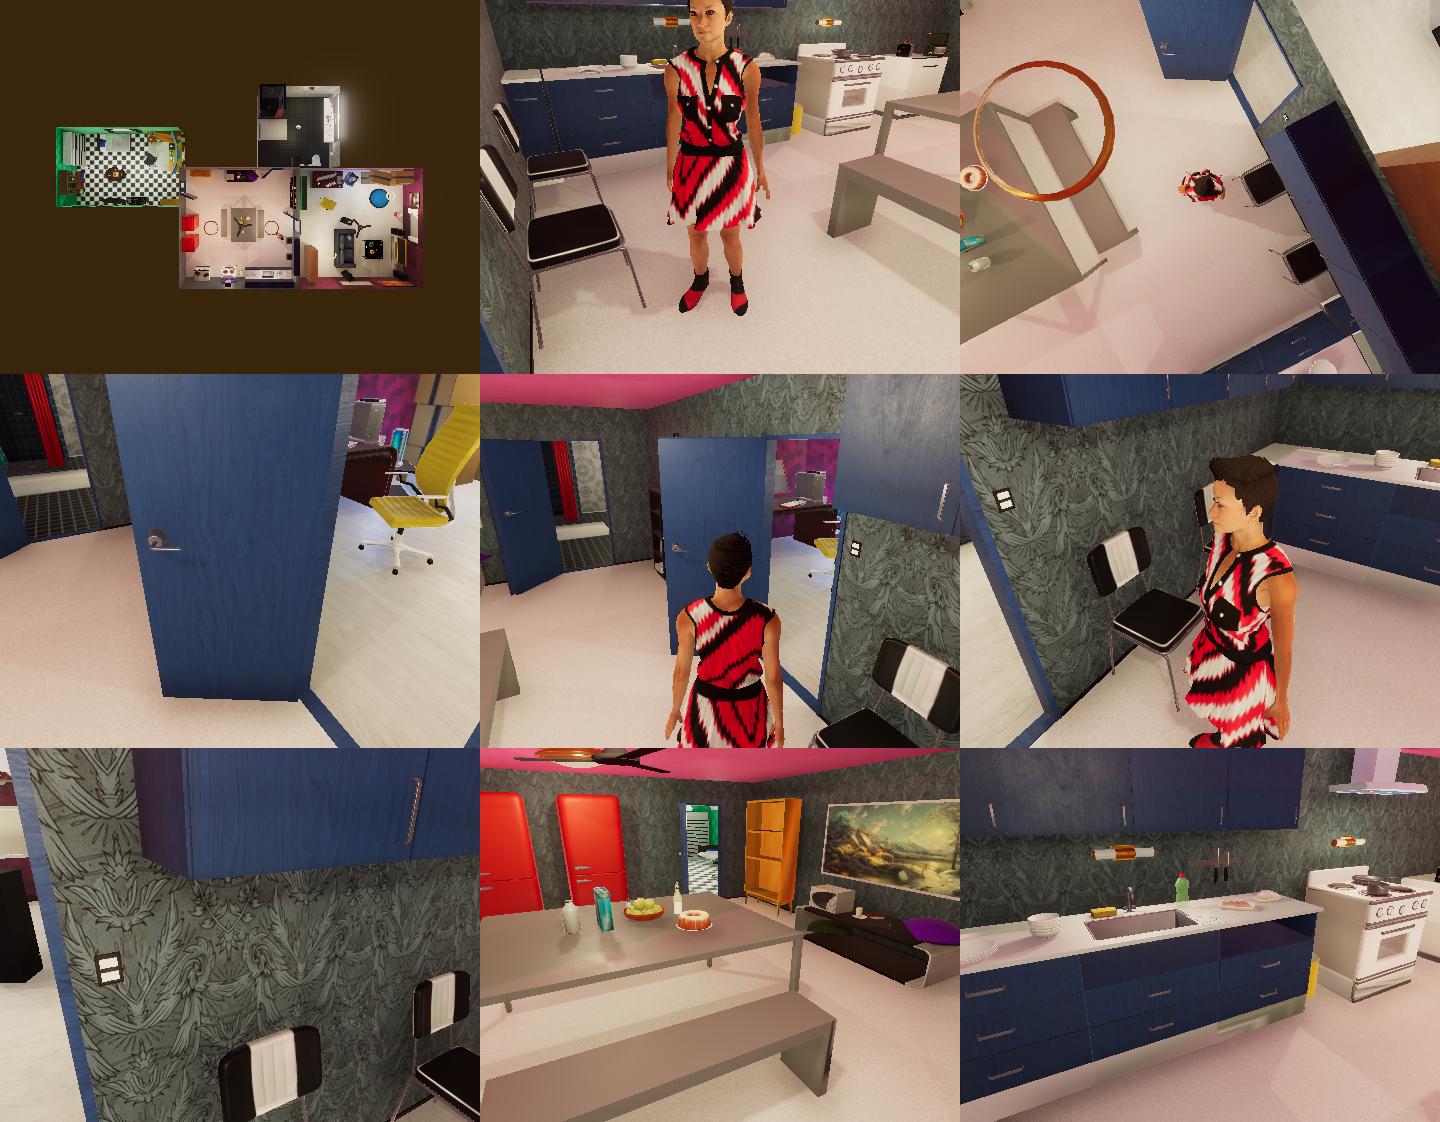

In [31]:
import json

comm.reset(6)
state_index = {'OPEN': 0, 'CLOSED': 1, 'ON': 2, 'OFF': 3, 'CLEAN':4}
room = {'bathroom', 'kitchen', 'livingroom', 'bedroom'}

properties = open('D:/code/virtualhome/resources/properties_data_all.json')
properties = json.load(properties)
properties['bathroom'] = []
properties['kitchen'] = []
properties['livingroom'] = []
properties['bedroom'] = []
properties['kitchencounterdrawer'] = properties.pop('kitchencounterdrawers')

def create_character(character, room):
    comm.add_character(character, initial_room=room)
    _, graph = comm.environment_graph()
    character_index = [node['id'] for node in graph['nodes'] if node['class_name'] == 'character'][-1]
    return character_index

def get_rooms_id():
    _, graph = comm.environment_graph()
    rooms_id = [node['id'] for node in graph['nodes'] if node['category'] == 'Rooms']
    return set(rooms_id)

def get_visible_objects_id(character_index):
    _, graph = comm.environment_graph()
    room_id = [edge['to_id'] for edge in graph['edges'] if edge['from_id'] == character_index and edge['relation_type'] == 'INSIDE'][-1]
    visible_objects_id_set = [edge['from_id'] for edge in graph['edges'] if edge['to_id'] == room_id and edge['relation_type'] == 'INSIDE' and edge['from_id'] != character_index]
    visible_objects_id_set = set(visible_objects_id_set)
    return visible_objects_id_set

def get_observations(character_index, visible_objects_id_set):
    _, graph = comm.environment_graph()
    character_position = [node for node in graph['nodes'] if node['id'] == character_index][0]['obj_transform']['position']
    observations = {}
    for node in graph['nodes']:
        if node['id'] in visible_objects_id_set:
            states_vector = [0, 0, 0, 0, 0, 0]
            if len(node['states']) == 0:
                states_vector[-1] = 1
            for state in node['states']:
                states_vector[state_index[state]] += 1
            observation = {'name': node['class_name'],
                           'state': states_vector,
                           'position': node['obj_transform']['position'] + list(np.array(node['obj_transform']['position']) - np.array(character_position))
                           }
            observations[node['id']] = observation
    return observations

def get_relationships(character_index, observations):
    _, graph = comm.environment_graph()
    room_id = [edge['to_id'] for edge in graph['edges'] if edge['from_id'] == character_index and edge['relation_type'] == 'INSIDE'][-1]
    sitting_edges = set()
    close_edges = set()
    inside_edges = set()
    hold_edges = set()
    for edge in graph['edges']:
        if edge['to_id'] in observations and edge['from_id'] == character_index:
            if edge['relation_type'] == 'SITTING':
                sitting_edges.add(edge['to_id'])
            elif edge['relation_type'] == 'CLOSE':
                close_edges.add(edge['to_id'])
            elif edge['relation_type'] == 'HOLDS_RH' or edge['relation_type'] == 'HOLDS_LH':
                hold_edges.add(edge['to_id'])
        if edge['from_id'] in observations:
            if edge['relation_type'] == 'INSIDE' and edge['to_id'] != room_id and 'CONTAINERS' in properties[observations[edge['to_id']]['name']] and observations[edge['to_id']]['state'][1] == 1:
                inside_edges.add(edge['from_id'])

    relationships = {'sitting': sitting_edges, 'close': close_edges, 'inside': inside_edges, 'hold': hold_edges}
    return relationships

character_id = create_character('chars/Female2', 'kitchen')
rooms_id = get_rooms_id()
visible_objects_id = get_visible_objects_id(character_id)
visible_objects_id = visible_objects_id.union(rooms_id)
partial_observation = get_observations(character_id, visible_objects_id)
object_relationships = get_relationships(character_id, partial_observation)

_, nc = comm.camera_count()
indices = range(nc - 9, nc)
imgs_prev = get_scene_cameras(comm, indices)
display_grid_img(imgs_prev, nrows=3)

# Extract data

In [71]:
import torch
action_index = {'standup': 0, 'walk': 1, 'sit': 2, 'grab': 3, 'open': 4, 'close': 5, 'switchon': 6, 'switchoff': 7, 'put': 8, 'putin': 9}

goal = ['ON (coffeepot, kitchentable): 1']
history = []
coffeepot_id = [object_id for object_id in partial_observation if partial_observation[object_id]['name'] == 'coffeepot'][-1]
kitchentable_id = [object_id for object_id in partial_observation if partial_observation[object_id]['name'] == 'kitchentable'][-1]
script = ['<char0> [walk] <coffeepot> ({})'.format(coffeepot_id), '<char0> [grab] <coffeepot> ({})'.format(coffeepot_id), '<char0> [walk] <kitchentable> ({})'.format(kitchentable_id), '<char0> [put] <coffeepot> ({}) <kitchentable> ({})'.format(coffeepot_id, kitchentable_id)]

batch = []

for script_instruction in script:
    rooms_id = get_rooms_id()
    visible_objects_id = get_visible_objects_id(character_id)
    visible_objects_id = visible_objects_id.union(rooms_id)
    partial_observation = get_observations(character_id, visible_objects_id)
    object_relationships = get_relationships(character_id, partial_observation)

    word = script_instruction.split(' ')
    action = word[1][1: -1]
    action_label = torch.tensor([action_index[action]])
    object_label = []
    if len(word) == 2:
        object_label = torch.tensor(object_label)
    elif len(word) == 4:
        obj_id = int(word[3][1: -1])
        for a, b in enumerate(partial_observation):
            if b == obj_id:
                object_label.append(a)
        object_label = torch.tensor(object_label)
    elif len(word) == 6:
        obj_id1 = int(word[3][1: -1])
        obj_id2 = int(word[5][1: -1])
        for a, b in enumerate(partial_observation):
            if b == obj_id1 or b == obj_id2:
                object_label.append(a)
        object_label = torch.tensor(object_label)
    data = {'goal': goal, 'history': history.copy(), 'observations': partial_observation, 'relationships': object_relationships, 'action_label': action_label, 'object_label': object_label}

    batch.append(data)

    history.append(script_instruction)

    comm.render_script([script_instruction], recording=False, skip_animation=True)

batch = np.array(batch)
print(batch)

[{'goal': ['ON (coffeepot, kitchentable): 1'], 'history': [], 'observations': {11: {'name': 'bathroom', 'state': [0, 0, 0, 0, 0, 1], 'position': [-3.784, 0.0, 8.75, 1.7624735000000005, 4.567206e-06, 4.80341387]}, 56: {'name': 'kitchen', 'state': [0, 0, 0, 0, 0, 1], 'position': [-3.75, 0.0, 6.25, 1.7964735000000003, 4.567206e-06, 2.30341387]}, 57: {'name': 'floor', 'state': [0, 0, 0, 0, 0, 1], 'position': [-3.75, 0.0, 6.25, 1.7964735000000003, 4.567206e-06, 2.30341387]}, 58: {'name': 'floor', 'state': [0, 0, 0, 0, 0, 1], 'position': [-3.74999976, 0.0, 3.75000024, 1.7964737400000002, 4.567206e-06, -0.19658589000000015]}, 59: {'name': 'floor', 'state': [0, 0, 0, 0, 0, 1], 'position': [-3.74999952, 0.0, 1.25000048, 1.7964739800000005, 4.567206e-06, -2.6965856500000003]}, 60: {'name': 'floor', 'state': [0, 0, 0, 0, 0, 1], 'position': [-6.249999, 0.0, 1.25, -0.7035254999999996, 4.567206e-06, -2.69658613]}, 61: {'name': 'floor', 'state': [0, 0, 0, 0, 0, 1], 'position': [-6.24999952, 0.0, 3.75

# Data looader

In [72]:
class DataLoader:
    def __init__(self, data, batch_size):
        """
        data: an array containing numerous dictionaries. Each dictionary is in the form of {'goal': a list containing multiple predicates, e.g. ['INSIDE (cutleryfork, dishwasher): 3','ON (wineglass, sink): 2'], 'history': a list containing all previous actions, e.g. ['<walk> [kitchen]', '<put> [apple] <in> [cabinet]'], 'observations': a dictionary mapping the visible object (including all rooms) id to name, state vector and position vector, 'relationships': a dictionary containing 4 relationship dictionary: sitting, close, inside, hold, 'action label': a torch tensor of size (1), showing the true action label, 'object label': a torch tensor of size (0) or (1) or (2), showing the true object labels}
        """
        self.data = data
        self.batch_size = batch_size

    def __iter__(self):
        """
        This class is an iterable that yields a batch of dictionaries.

        return: a numpy array containing batch_size steps of dictionaries.
        """
        num_data = self.data.shape[0]
        while True:
            extract_id = np.random.choice(num_data, size=self.batch_size, replace=False)

            yield self.data[extract_id]

In [73]:
train_dataset = DataLoader(batch[:2], 2)
val_dataset = DataLoader(batch[2:], 1)

# Construct the LM framework

Create word embeddings and tokenizer

In [74]:
from transformers import GPT2Tokenizer, GPT2Model

def get_tokenizer(lm):
    tokenizer = GPT2Tokenizer.from_pretrained(lm)
    return tokenizer

def get_word_embeddings(lm):
    model = GPT2Model.from_pretrained(lm)
    word_embeddings = model.wte.weight
    return word_embeddings

gpt2_tokenizer = get_tokenizer('gpt2')
gpt2_word_embeddings = get_word_embeddings('gpt2')

Define embedding function

In [75]:
def get_embeddings(word, tokenizer, word_embeddings):
    token = tokenizer.encode(word)
    embeddings = word_embeddings[token,:].detach().numpy()
    return embeddings

action_goals = 'put three cutleryfork inside dishwasher, put two wineglass on sink, put one waterglass inside dishwasher, close the dishwasher, turnon the dishwasher.'
gpt2_goal_embeddings = get_embeddings(action_goals, gpt2_tokenizer, gpt2_word_embeddings)
action_history = 'I have walked to the kitchen, grabbed the apple'
gpt2_history_embeddings = get_embeddings(action_history, gpt2_tokenizer, gpt2_word_embeddings)

Define the function to add constraints on the action and object predictions

In [76]:
action_space = {0: 'standup', 1: 'walk', 2:'sit', 3:'grab', 4:'open', 5:'close', 6:'switchon', 7:'switchoff', 8:'put', 9: 'putin'}

def judge_standup(sitting_edges):
    cond1 = len(sitting_edges) > 1
    return True if cond1 else False

def judge_walk(sitting_edges, inside_edges, hold_edges, obj, index):
    cond1 = len(sitting_edges) == 0
    cond2 = index not in inside_edges
    cond3 = obj in room
    cond4 = index not in hold_edges
    return True if cond1 and (cond2 or cond3) and cond4 else False

def judge_sit(sitting_edges, close_edges, obj, index):
    cond1 = len(sitting_edges) == 0
    cond2 = index in close_edges
    cond3 = 'SITTABLE' in properties[obj] if obj in properties else False
    return True if cond1 and cond2 and cond3 else False

def judge_grab(close_edges, inside_edges, hold_edges, obj, index):
    cond1 = 'GRABBABLE' in properties[obj] if obj in properties else False
    cond2 = obj != 'water'
    cond3 = index in close_edges
    cond4 = index not in inside_edges
    cond5 = index not in hold_edges
    cond6 = len(hold_edges) < 2
    return True if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 else False

def judge_open(observations, close_edges, inside_edges, hold_edges, obj, index):
    cond1 = 'CAN_OPEN' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][1] = 1
    cond3 = index in close_edges
    cond4 = index not in inside_edges
    cond5 = index not in hold_edges
    cond6 = len(hold_edges) < 2
    return True if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 else False

def judge_close(observations, close_edges, inside_edges, hold_edges, obj, index):
    cond1 = 'CAN_OPEN' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][0] = 1
    cond3 = index in close_edges
    cond4 = index not in inside_edges
    cond5 = index not in hold_edges
    cond6 = len(hold_edges) < 2
    return True if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 else False

def judge_switchon(observations, close_edges, obj, index):
    cond1 = 'HAS_SWITCH' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][3] == 1
    cond3 = index in close_edges
    return True if cond1 and cond2 and cond3 else False

def judge_switchoff(observations, close_edges, obj, index):
    cond1 = 'HAS_SWITCH' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][2] == 1
    cond3 = index in close_edges
    return True if cond1 and cond2 and cond3 else False

def judge_put(hold_edges, close_edges, index1, index2):
    cond1 = index1 in hold_edges
    cond2 = index2 in close_edges
    return True if cond1 and cond2 else False

def judge_putin(observations, hold_edges, close_edges, index1, index2):
    cond1 = index1 in hold_edges
    cond2 = index2 in close_edges
    cond3 = observations[index2]['state'][1] != 1
    return True if cond1 and cond2 and cond3 else False

def judge_0(relationships):
    sitting_edges = relationships['sitting']
    return judge_standup(sitting_edges)

def judge_1(action, obj, index, relationships, observations):
    sitting_edges = relationships['sitting']
    close_edges = relationships['close']
    inside_edges = relationships['inside']
    hold_edges = relationships['hold']
    if action == 'walk':
        return judge_walk(sitting_edges, inside_edges, hold_edges, obj, index)
    elif action == 'sit':
        return judge_sit(sitting_edges, close_edges, obj, index)
    elif action == 'grab':
        return judge_grab(close_edges, inside_edges, hold_edges, obj, index)
    elif action == 'open':
        return judge_open(observations, close_edges, inside_edges, hold_edges, obj, index)
    elif action == 'close':
        judge_close(observations, close_edges, inside_edges, hold_edges, obj, index)
    elif action == 'switchon':
        return judge_switchon(observations, close_edges, obj, index)
    elif action == 'switchoff':
        return judge_switchoff(observations, close_edges, obj, index)

def judge_2(action, index1, index2, relationships, observations):
    close_edges = relationships['close']
    hold_edges = relationships['hold']
    if action == 'put':
        return judge_put(hold_edges, close_edges, index1, index2)
    elif action == 'putin':
        judge_putin(observations, hold_edges, close_edges, index1, index2)

Training and evaluating algorithm

In [77]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as f

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

def array_to_2d_tensor(array):
    if len(array.shape) > 1:
        return torch.tensor(array)
    return torch.tensor(array).unsqueeze(0)

def gpt2_model(embeddings):
    model = GPT2Model.from_pretrained('gpt2')
    return model(inputs_embeds=embeddings).last_hidden_state

class LM(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layer in LM framework
        self.state_fc = nn.Linear(6, 3 * 768)

        self.position_fc1 = nn.Linear(6, 3 * 768)
        self.relu = nn.ReLU(inplace=True)
        self.position_fc2 = nn.Linear(3 * 768, 3 * 768)

        self.object_fc = nn.Linear(7 * 768, 768)

        self.action_fc = nn.Linear(768, 10)

    def forward(self, goal, history, observations, relationships, action_label, object_label, train_or_test='train'):
        """
        Forward pass of the neural network

        goal: a list containing multiple predicates, e.g. ['INSIDE (cutleryfork, dishwasher): 3','ON (wineglass, sink): 2']
        history: a list containing all previous actions, e.g. ['<walk> [kitchen]', '<put> [apple] <in> [cabinet]']
        observations: a dictionary mapping the visible object (including all rooms) id to name, state vector and position vector
        relationships: a dictionary containing 4 relationship dictionary: sitting, close, inside, hold
        action label: a torch tensor of size (1), showing the true action label
        object label: a torch tensor of size (0) or (1) or (2), showing the true object labels

        return: a tuple (loss, accuracy) of two torch Float scalars representing the cross entropy loss and mean accuracy of the batch
        """
        templated_goal = goal_translate(goal)
        templated_history = history_translate(history)

        # embed goal
        goal_embeddings = get_embeddings(templated_goal, gpt2_tokenizer, gpt2_word_embeddings)
        goal_embeddings = array_to_2d_tensor(goal_embeddings)

        # embed history
        history_embeddings = get_embeddings(templated_history, gpt2_tokenizer, gpt2_word_embeddings)
        history_embeddings = array_to_2d_tensor(history_embeddings)

        # embed partial observation
        observation_embeddings = []
        for visible_object in observations.values():
            # embed name
            name_embeddings = get_embeddings(visible_object['name'], gpt2_tokenizer, gpt2_word_embeddings)
            name_embeddings = np.mean(name_embeddings, 0)
            name_embeddings = array_to_2d_tensor(name_embeddings)

            # embed state
            state = torch.tensor(visible_object['state'], dtype=torch.float)
            state_embeddings = self.state_fc(state).unsqueeze(0)

            # embed position
            position = torch.tensor(visible_object['position'], dtype=torch.float)
            position_embeddings = self.position_fc1(position)
            position_embeddings = self.relu(position_embeddings)
            position_embeddings = self.position_fc2(position_embeddings).unsqueeze(0)

            # concatenate object embeddings and pass through fc layer
            object_embeddings = torch.cat((name_embeddings, state_embeddings, position_embeddings), 1)
            object_embeddings = self.object_fc(object_embeddings).view(-1, 768)
            observation_embeddings.append(object_embeddings)

        # concatenate all object embeddings
        observation_embeddings = torch.cat(observation_embeddings)

        # concatenate goal, history and observations and pass them through LM
        action_embeddings = torch.cat((goal_embeddings, history_embeddings, observation_embeddings))
        action_embeddings = gpt2_model(action_embeddings[:1023])

        # pass LM output to the average pooling to get contextualized feature and predict the next action
        contextualized_feature = torch.mean(action_embeddings, 0)
        contextualized_feature_after_fc = self.action_fc(contextualized_feature)
        action_prediction = torch.argsort(contextualized_feature_after_fc, descending=True)

        # pass the observation embeddings through LM and compute the inner product of each object feature with contextualized feature, then make the object prediction
        object_feature = gpt2_model(observation_embeddings[:1023])
        inner_product = object_feature.unsqueeze(1).bmm(contextualized_feature.repeat(object_feature.shape[0]).view(object_feature.shape[0], -1, 1)).squeeze()
        object_prediction = torch.argsort(inner_product, descending=True)

        next_predicate, next_index = self.predictor(action_prediction, object_prediction, observations, relationships)
        if train_or_test == 'train':
            loss = self.compute_loss(contextualized_feature_after_fc, inner_product, action_label, object_label)
            accuracy = self.compute_accuracy(next_index, action_label, object_label)
            return loss, accuracy
        else:
            return next_predicate

    def predictor(self, action_prediction, object_prediction, observations, relationships):
        """
        Compute the loss and accuracy

        action_prediction: a torch tensor with a size (10), showing the probability of 10 actions
        object_prediction: a torch tensor with a size (len(observations)), showing the probability of all visible objects
        observations: a dictionary mapping the visible object (including all rooms) id to name, state vector and position vector
        relationships: a dictionary containing 4 relationship dictionary: sitting, close, inside, hold

        return: a predicate string in the form of VirtualHome format without character, e.g. '[walk] <chair> (1)'
        """
        for action_id in action_prediction:
            if int(action_id.numpy()) == 0 and judge_0(relationships):
                return '[{}]'.format(action_space[int(action_id.numpy())]), (action_id, torch.tensor([-1]), torch.tensor([-1]))

            elif 1 <= int(action_id.numpy()) <= 7:
                action = action_space[int(action_id.numpy())]
                for object_id in object_prediction:
                    obj = observations[list(observations.keys())[int(object_id.numpy())]]['name']
                    index = list(observations.keys())[int(object_id.numpy())]
                    if judge_1(action, obj, index, relationships, observations):
                        return '[{}] <{}> ({})'.format(action, obj, index), (action_id, object_id, torch.tensor([-1]))

            elif int(action_id.numpy()) >= 8:
                action = action_space[int(action_id.numpy())]
                for i in range(len(object_prediction)):
                    obj1 = observations[list(observations.keys())[int(object_prediction[i].numpy())]]['name']
                    index1 = list(observations.keys())[int(object_prediction[i].numpy())]
                    for j in range(i + 1, len(object_prediction)):
                        obj2 = observations[list(observations.keys())[int(object_prediction[j].numpy())]]['name']
                        index2 = list(observations.keys())[int(object_prediction[j].numpy())]
                        if judge_2(action, index1, index2, relationships, observations):
                            return '[{}] <{}> ({}) <{}> ({})'.format(action, obj1, index1, obj2, index2), (action_id, object_prediction[i], object_prediction[j])

    def compute_loss(self, contextualized_feature_after_fc, inner_product, action_label, object_label):
        """
        Compute the cross entropy loss

        contextualized_feature_after_fc: a torch tensor with a size (10), showing the probability of 10 actions
        inner_product: a torch tensor with a size (len(observations)), showing the probability of all visible objects
        action label: a torch tensor of size (1), showing the true action label
        object label: a torch tensor of size (0) or (1) or (2), showing the true object labels

        return: the cross entropy loss of the action and objects
        """
        if object_label.shape[0] == 0:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label)
        elif object_label.shape[0] == 1:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label) + f.cross_entropy(inner_product.unsqueeze(0), object_label)
        elif object_label.shape[0] == 2:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label) + f.cross_entropy(inner_product.unsqueeze(0), object_label[0].unsqueeze(0)) + f.cross_entropy(inner_product.unsqueeze(0), object_label[1].unsqueeze(0))

    def compute_accuracy(self, next_index, action_label, object_label):
        """
        Compute the accuracy

        next_index: a tuple with three torch tensors with size (1), each indicates the index of the action and objects
        action label: a torch tensor of size (1), showing the true action label
        object label: a torch tensor of size (0) or (1) or (2), showing the true object labels

        return: the cross entropy loss of the action and objects
        """
        if object_label.shape[0] == 0:
            action_accuracy = 1 if int(next_index[0].numpy()) == int(action_label[0].numpy()) else 0
            return action_accuracy
        elif object_label.shape[0] == 1:
            action_accuracy = 0.5 if int(next_index[0].numpy()) == int(action_label[0].numpy()) else 0
            object_accuracy = 0.5 if int(next_index[1].numpy()) == int(object_label[0].numpy()) else 0
            return action_accuracy + object_accuracy
        elif object_label.shape[0] == 2:
            action_accuracy = 1/3 if int(next_index[0].numpy()) == int(action_label[0].numpy()) else 0
            object_accuracy1 = 1/3 if int(next_index[1].numpy()) == int(object_label[0].numpy()) else 0
            object_accuracy2 = 1/3 if int(next_index[2].numpy()) == int(object_label[1].numpy()) else 0
            return action_accuracy + object_accuracy1 + object_accuracy2

device = 'cpu'

def train(net, num_steps):
    """
    Train the input neural network for num_steps

    net: LM framework
    num_steps: number of batches to train for

    return: the trained net, the training accuracies per step, and the validation accuracies per steps
    """
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)
    train_accuracies = []
    val_accuracies = []
    for step, batch in zip(range(num_steps), train_dataset):
        train_loss = torch.tensor([0], dtype=torch.float)
        train_accuracy = 0
        batch_size = batch.shape[0]
        for data in batch:
            goal, history, observations, relationships, action_label, object_label = data['goal'], data['history'], data['observations'], data['relationships'], data['action_label'], data['object_label']
            loss, accuracy = net(goal, history, observations, relationships, action_label, object_label, 'train')

            train_loss += loss / batch_size
            train_accuracy += accuracy / batch_size

        opt.zero_grad()
        train_loss.backward()
        opt.step()

        train_accuracies.append(train_accuracy)
        if (step + 1) % 1 == 0:
            val_loss, val_accuracy = validate(net, val_dataset)
            val_accuracies.append(val_accuracy)
            print('step=%s   train(loss=%.5g, accuracy=%.5g)  val(loss=%.5g, accuracy=%.5g)' % (step + 1, train_loss, train_accuracy, val_loss, val_accuracy))
    return net, train_accuracies, val_accuracies

def validate(net, val_dataset):
    """
    Evalate the trained net on val_dataset

    net: LM framework
    val_dataset: validation dataset

    return: a tuple (val_loss, val_accuracy)
    """
    with torch.no_grad():
        batch = next(iter(val_dataset))
        batch_size = batch.shape[0]
        loss_sum = torch.tensor([0], dtype=torch.float)
        accuracy_sum = 0
        for data in batch:
            goal, history, observations, relationships, action_label, object_label = data['goal'], data['history'], data['observations'], data['relationships'], data['action_label'], data['object_label']
            loss, accuracy = net(goal, history, observations, relationships, action_label, object_label, 'train')

            loss_sum += loss / batch_size
            accuracy_sum += accuracy / batch_size

        val_loss, val_accuracy = loss_sum, accuracy_sum
    return val_loss, val_accuracy

step=1   train(loss=57.58, accuracy=0.25)  val(loss=3868, accuracy=0)
step=2   train(loss=4282.1, accuracy=0.25)  val(loss=696.1, accuracy=0)
step=3   train(loss=148.47, accuracy=0.25)  val(loss=432.38, accuracy=0)
step=4   train(loss=44.16, accuracy=0.25)  val(loss=236.95, accuracy=0)
step=5   train(loss=1.4842, accuracy=0.75)  val(loss=353.98, accuracy=0)
step=6   train(loss=1.2322, accuracy=0.75)  val(loss=348.65, accuracy=0)
step=7   train(loss=1.0614, accuracy=0.75)  val(loss=339.57, accuracy=0)
step=8   train(loss=0.90315, accuracy=0.75)  val(loss=203.75, accuracy=0)
step=9   train(loss=0.77943, accuracy=0.75)  val(loss=330.8, accuracy=0)
step=10   train(loss=0.72082, accuracy=1)  val(loss=333.11, accuracy=0)


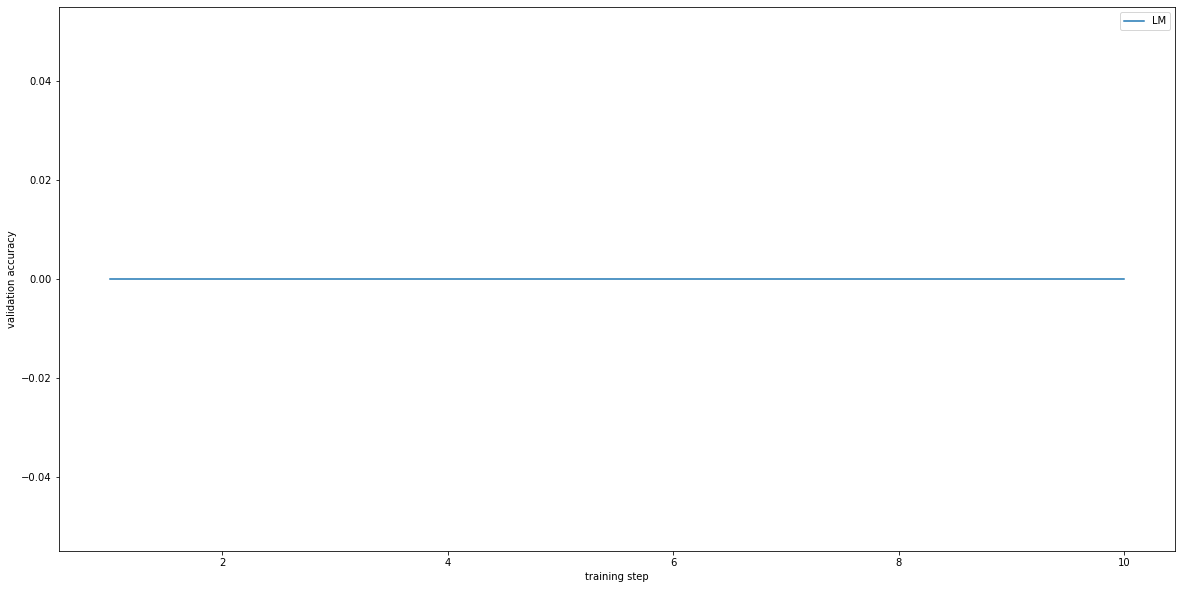

In [78]:
nets = {}
train_steps = 10 # change as needed
plt.figure(figsize=(20, 10))

Net = LM
nets[Net], train_accs, val_accs = train(Net(), train_steps)

plt.plot((1 + np.arange(len(val_accs))), val_accs, label=Net.__name__)
plt.xlabel('training step')
plt.ylabel('validation accuracy')
plt.legend()
plt.show()

# Test the model

In [84]:
test_goal = ['ON (coffeepot, kitchentable): 1']
test_hostory = []
success_predicate = ['[put] <coffeepot> <kitchentable>']
comm.reset(6)

character_id = create_character('chars/Female2', 'livingroom')
rooms_id = get_rooms_id()

num = 0
while num < 5:
    visible_objects_id = get_visible_objects_id(character_id)
    visible_objects_id = visible_objects_id.union(rooms_id)
    partial_observation = get_observations(character_id, visible_objects_id)
    object_relationships = get_relationships(character_id, partial_observation)

    next_predicate = nets[Net](test_goal, test_hostory, partial_observation, object_relationships, None, None, 'test')
    print(next_predicate)
    if next_predicate in success_predicate:
        break

    comm.render_script(['<char0> ' + next_predicate], recording=False, skip_animation=True)

    test_hostory.append(next_predicate)
    num += 1
print(test_hostory)

[walk] <book> (264)
[walk] <book> (264)
[walk] <book> (264)
[walk] <book> (264)
[walk] <book> (264)
['[walk] <book> (264)', '[walk] <book> (264)', '[walk] <book> (264)', '[walk] <book> (264)', '[walk] <book> (264)']
